<a href="https://colab.research.google.com/github/Pedro-HFelix/.Net-Api-Agendamento/blob/main/TitanicTrabalho.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [124]:
# from google.colab import drive
# drive.mount('/content/drive')

Importar libs para o funcionamento do projeto

In [125]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb

Analisando as variaveis e carregando o dataset

In [126]:
titanic_df = pd.read_csv('/content/sample_data/train.csv')
display(titanic_df.head())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


None

Em uma análise rápida e inicial, identifiquei que a coluna PassengerId não parece ser necessária. A variável Survived é o nosso dado-alvo, ou seja, o resultado que queremos prever.

Notei também que alguns dados estão com valores nulos e outros não possuem um tipo de dado bem definido (como é o caso da coluna Cabin). Para entender melhor o conjunto, farei uma análise descritiva de cada uma das variáveis.

PassengerId: Id do passageiro. Em si, não existe qualquer importância disso para a análise de dados presente aqui. Sendo dados inclusive sequenciais, não tendo ou existindo qualquer tipo de necessidade de tratarmos ou incluirmos isso para o tratamento de dados.

Survived: Esta é possivelmente a variável mais importante aqui, sendo a variável responsável por classificarmos se alguém sobreviveu ou não. Ela deve ser a variável dado-alvo para podermos classificar algo.

Pclass: A classe em que estão as pessoas. Aqui é importante, pois os passageiros de classe mais alta tiveram privilégio em detrimento dos outros. Para a análise do problema, essa coluna vai ser de extrema importância.

Name: O nome, nesse caso, não é necessário. Porém, caso venha a existir algum dado nulo em Sex, pode-se descobrir o mesmo pelo nome, extraindo informações importantes aqui.

Sex: O sexo, em si, é algo de extrema importância aqui, não possuindo valores nulos e estando perfeitamente preenchidos. Aqui tem uma importância devido ao fato de que em casos de acidente existe um padrão: "crianças e mulheres primeiro". Tendo isso em vista, pela lógica, isso deve possuir algum tipo de importância.

Age: Idade também é de extrema importância pelo mesmo conceito que citei acima. Devido a isso, deve também existir um tratamento para os dados de Age para deixar de ser apenas um dado quantitativo e virar um dado qualitativo.

SibSp: Número de cônjuges ou irmãos no Titanic. Esse aqui, em específico, não é de fato importante. Não consigo ver a necessidade desses dados para o Titanic em relação a outros dados. OBS: Creio que se juntar o tamanho da família, pode ser possível conseguir algum dado valioso.

Parch: Número de pais e filhos a bordo. Mesmo caso acima.

Ticket: Número do ticket.

Fare: Tarifa do passageiro.

Cabin: Aqui seria importante, porém, devido ao fato de que muitos dos dados estão nulos, creio que seja melhor descartar.

Embarked: Ao pesquisar o contexto do Titanic, descobri que ele teve 3 pontos de embarque diferentes, o que no dataset é representado por esta coluna com 3 valores. Os pontos de embarque foram Southampton (Na Inglaterra), representado pelo S, Cherbourg (França), representado pelo C, e por fim Queenstown (Irlanda), representando o Q. Possivelmente pode ter relação do local com a classe social, o que pode ajudar.

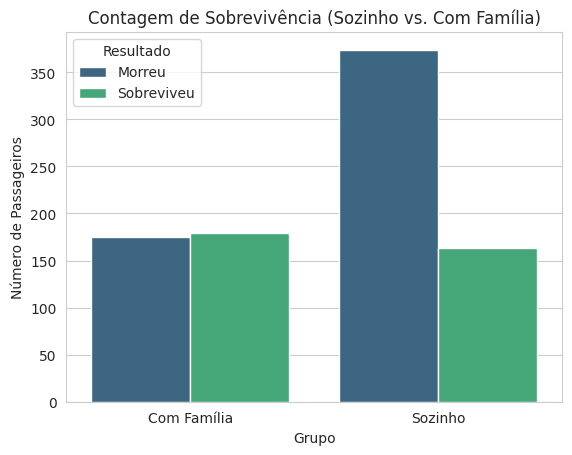

In [127]:
titanic_df['FamilySize'] = titanic_df['SibSp'] + titanic_df['Parch'] + 1

titanic_df['IsAlone'] = (titanic_df['FamilySize'] == 1).astype(int)

sns.countplot(data=titanic_df, x='IsAlone', hue='Survived', palette='viridis')
plt.title('Contagem de Sobrevivência (Sozinho vs. Com Família)')
plt.ylabel('Número de Passageiros')
plt.xlabel('Grupo')
plt.xticks(ticks=[0, 1], labels=['Com Família', 'Sozinho'])
handles, _ = plt.gca().get_legend_handles_labels()
plt.legend(handles, ['Morreu', 'Sobreviveu'], title='Resultado')
plt.show()

A principio se pode ver que os que estava sozinham tiveram um maior numero de morte, agora vem uma duvida, o tamanho da familia importa? Para isso irei gerar um teste para ver se familias pequenas, medias e grandes influenciam nessa dicição

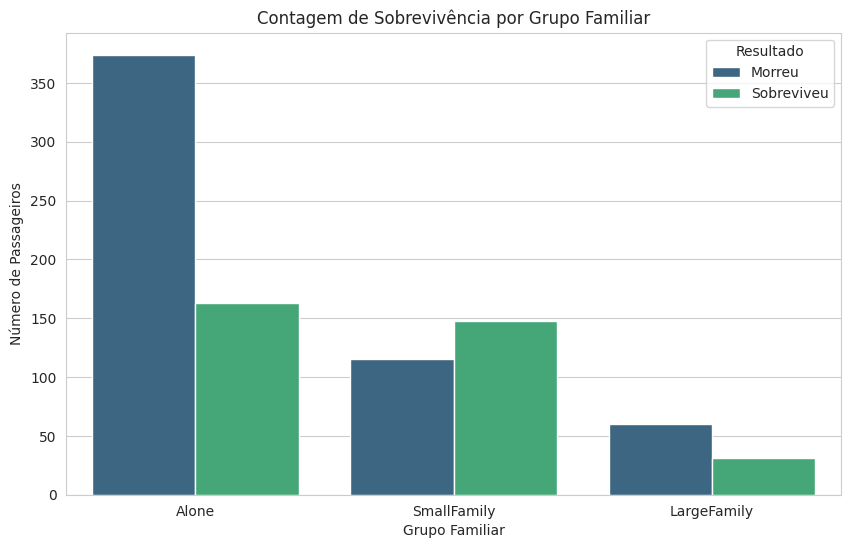

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,IsAlone,FamilyGroup
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2,0,SmallFamily
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2,0,SmallFamily
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,1,Alone
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2,0,SmallFamily
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,1,Alone


In [128]:
bins = [0, 1, 3, np.inf]
labels = ['Alone', 'SmallFamily', 'LargeFamily']
titanic_df['FamilyGroup'] = pd.cut(
    titanic_df['FamilySize'],
    bins=bins,
    labels=labels,
    right=True
)

plt.figure(figsize=(10, 6))
sns.countplot(
    data=titanic_df,
    x='FamilyGroup',
    hue='Survived',
    palette='viridis'
)

plt.title('Contagem de Sobrevivência por Grupo Familiar')
plt.xlabel('Grupo Familiar')
plt.ylabel('Número de Passageiros')

plt.legend(title='Resultado', labels=['Morreu', 'Sobreviveu'])

plt.show()

titanic_df.head()

Familias grandes, em proporção, foram os que mais morreramas,  depois os que estavam sozinhois e o familias pequenas tiveram um melhor proporção, tendo mais gente que sobreviveram.

Após isso, ja foi tratado alguns dados, em especifio o tamanho de familia, o que pode ver que ajuda. Agora sera cortados dados descenessarios que não ajudarão na predição e também trataviva de dados

In [129]:
mapa_portos = {
    'S': 0,
    'C': 1,
    'Q': 2
}
titanic_df['Embarked'] = titanic_df['Embarked'].map(mapa_portos)

titanic_df['Sex'] =titanic_df['Sex'].astype('category').cat.codes

titanic_df['Age'] = titanic_df['Age'].fillna(titanic_df['Age'].median())

bins = [-1, 12, 18, 60, float('inf')]

labels = [0, 1, 2, 3]

titanic_df['Age'] = pd.cut(titanic_df['Age'], bins=bins, labels=labels, right=True)

titanic_df['FamilySize'] = titanic_df['SibSp'] + titanic_df['Parch'] + 1

bins_family = [0, 1, 3, np.inf]


labels_family = [0, 1, 2]

titanic_df['FamilyGroup'] = pd.cut(
    titanic_df['FamilySize'],
    bins=bins_family,
    labels=labels_family,
    right=True
)

titanic_df['FamilyGroup'] = titanic_df['FamilyGroup'].fillna(0)


labels_fare = [0, 1, 2, 3]
titanic_df['Fare'] = pd.qcut(titanic_df['Fare'], 4, labels=labels_fare, duplicates='drop')

titanic_df

titanic_df = titanic_df.drop(columns=['Ticket', 'Cabin', 'Name', 'PassengerId', 'FamilySize', 'IsAlone', 'SibSp', 'Parch'])



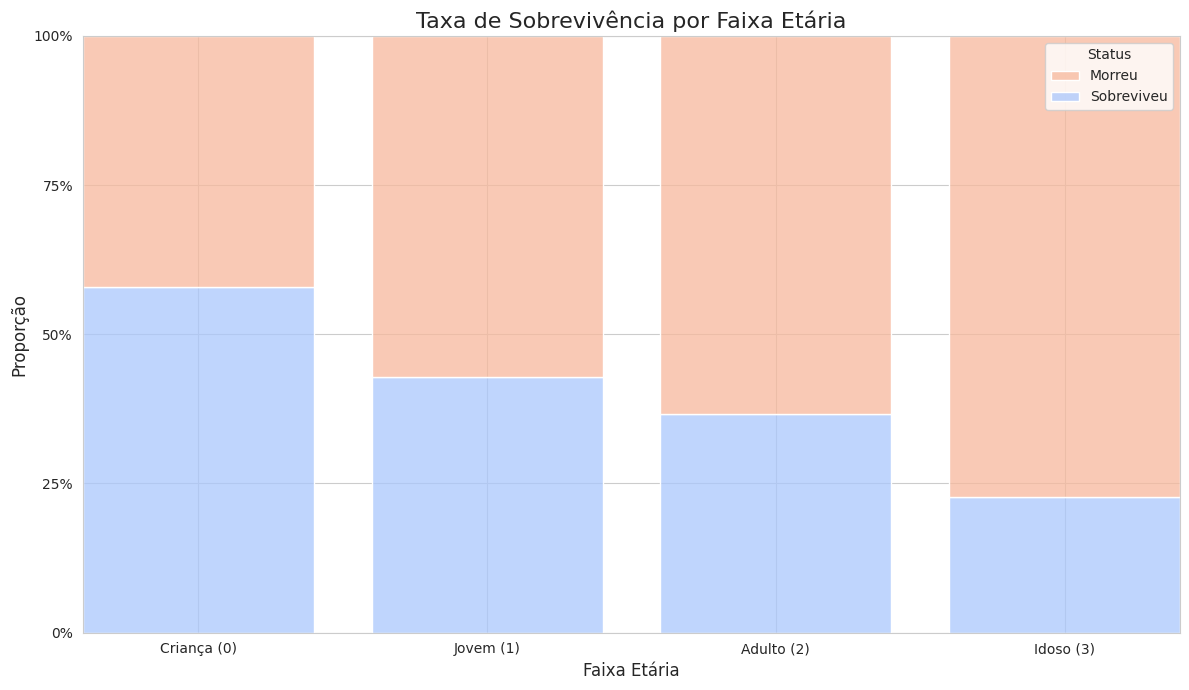

In [130]:
titanic_df['Status'] = titanic_df['Survived'].map({
    0: 'Morreu',
    1: 'Sobreviveu'
})

sns.set_style("whitegrid")
plt.figure(figsize=(12, 7))

ax = sns.histplot(
    data=titanic_df,
    x='Age',
    hue='Status',
    multiple='fill',
    discrete=True,
    palette='coolwarm_r',
    shrink=0.8
)

ax.set_title('Taxa de Sobrevivência por Faixa Etária', fontsize=16)
ax.set_xlabel('Faixa Etária', fontsize=12)
ax.set_ylabel('Proporção', fontsize=12)

ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(['Criança (0)', 'Jovem (1)', 'Adulto (2)', 'Idoso (3)'])

ax.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
ax.set_yticklabels(['0%', '25%', '50%', '75%', '100%'])

plt.tight_layout()
plt.show()

Alguns graficos para mais analises

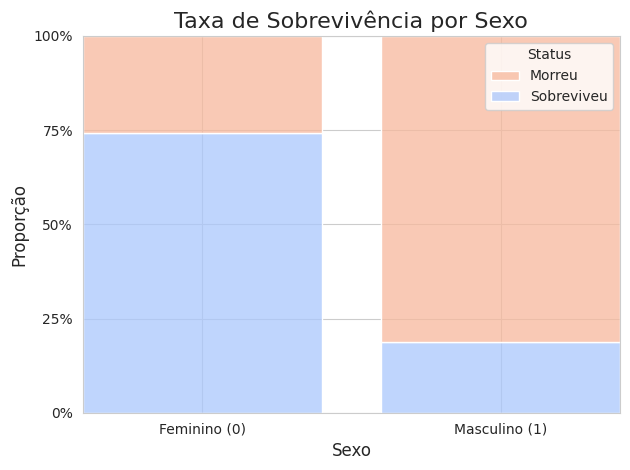

In [131]:
ax = sns.histplot(
    data=titanic_df,
    x='Sex',
    hue='Status',
    multiple='fill',
    discrete=True,
    palette='coolwarm_r',
    shrink=0.8
)

ax.set_title('Taxa de Sobrevivência por Sexo', fontsize=16)
ax.set_xlabel('Sexo', fontsize=12)
ax.set_ylabel('Proporção', fontsize=12)

ax.set_xticks([0, 1])
ax.set_xticklabels(['Feminino (0)', 'Masculino (1)'])
ax.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
ax.set_yticklabels(['0%', '25%', '50%', '75%', '100%'])

plt.tight_layout()
plt.show()

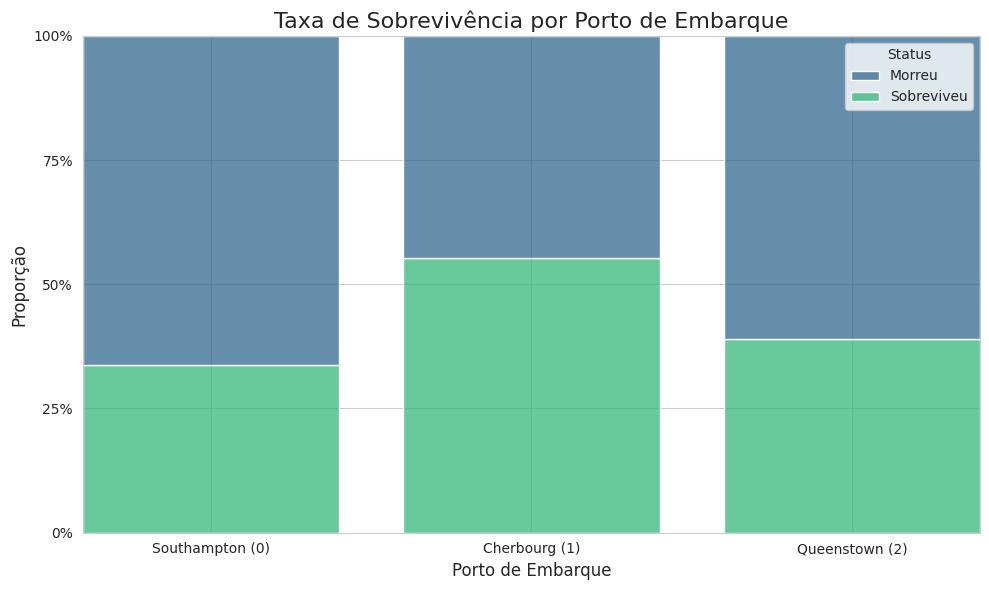

In [132]:
plt.figure(figsize=(10, 6))

ax = sns.histplot(
    data=titanic_df,
    x='Embarked',
    hue='Status',
    multiple='fill',
    discrete=True,
    palette='viridis',
    shrink=0.8
)

ax.set_title('Taxa de Sobrevivência por Porto de Embarque', fontsize=16)
ax.set_xlabel('Porto de Embarque', fontsize=12)
ax.set_ylabel('Proporção', fontsize=12)

ax.set_xticks([0, 1, 2])
ax.set_xticklabels(['Southampton (0)', 'Cherbourg (1)', 'Queenstown (2)'])
ax.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
ax.set_yticklabels(['0%', '25%', '50%', '75%', '100%'])

plt.tight_layout()
plt.show()

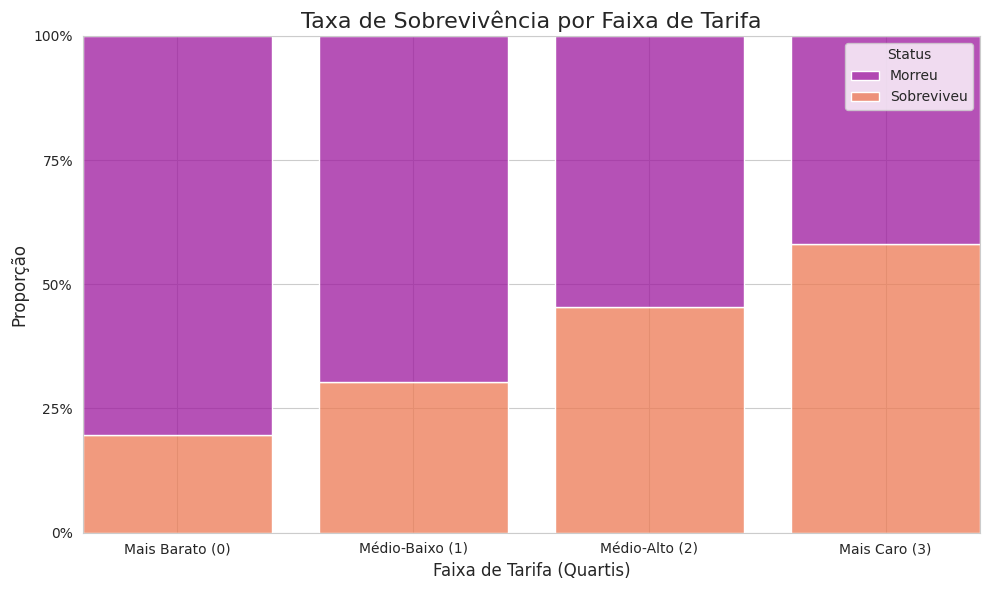

In [133]:
plt.figure(figsize=(10, 6))

ax = sns.histplot(
    data=titanic_df,
    x='Fare',
    hue='Status',
    multiple='fill',
    discrete=True,
    palette='plasma',
    shrink=0.8
)

ax.set_title('Taxa de Sobrevivência por Faixa de Tarifa', fontsize=16)
ax.set_xlabel('Faixa de Tarifa (Quartis)', fontsize=12)
ax.set_ylabel('Proporção', fontsize=12)

ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(['Mais Barato (0)', 'Médio-Baixo (1)', 'Médio-Alto (2)', 'Mais Caro (3)'])
ax.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
ax.set_yticklabels(['0%', '25%', '50%', '75%', '100%'])

plt.tight_layout()
plt.show()

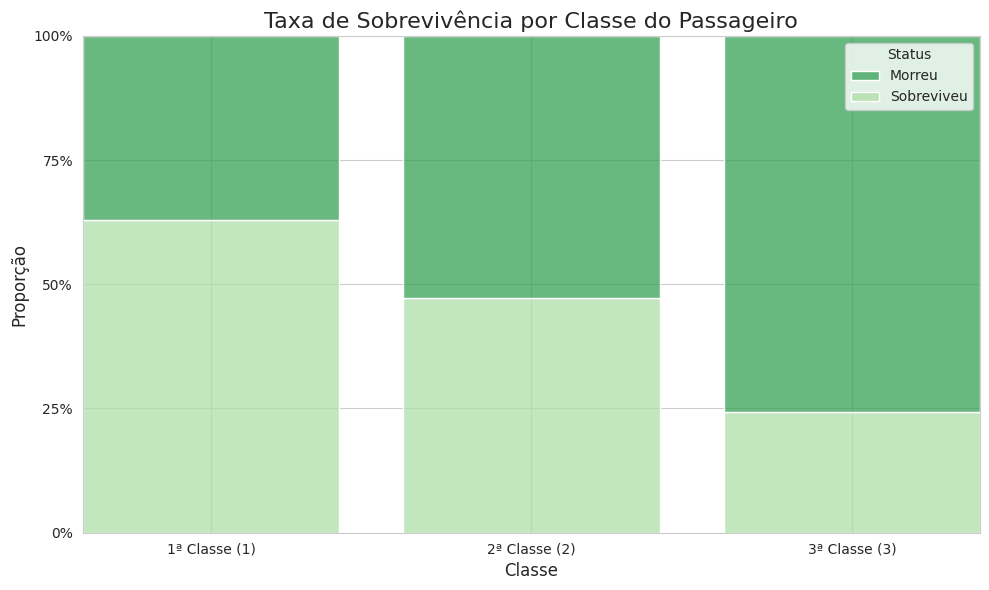

In [134]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

ax = sns.histplot(
    data=titanic_df,
    x='Pclass',
    hue='Status',
    multiple='fill',
    discrete=True,
    palette='Greens_r',
    shrink=0.8
)

ax.set_title('Taxa de Sobrevivência por Classe do Passageiro', fontsize=16)
ax.set_xlabel('Classe', fontsize=12)
ax.set_ylabel('Proporção', fontsize=12)

ax.set_xticks([1, 2, 3])
ax.set_xticklabels(['1ª Classe (1)', '2ª Classe (2)', '3ª Classe (3)'])

ax.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
ax.set_yticklabels(['0%', '25%', '50%', '75%', '100%'])

plt.tight_layout()
plt.show()

Após a analises podemos destacar algumas coisas:
Aqueles que tiveram tickets mais caros, ou seja, estavam em melhores locais no barco, tiverem uma maior taxa de sobrevivencia. Ademais, mulheres e familias 'pequenas' tiveram também uma maior proporção de sobrevivencia. E a faixa etaria fez uma escada de taxa de sobrevivencia, sendo quanto mais novo maior a chance de sobrevivencia. E creio que dos atributos analisados o de menor importancia seria o dos portos, por mais que o C teve uma maior proporção de sucesso, possivelmente por possuir passageiros de passagem e areas mais elavadas, para comprovar essa hipotese

/tmp/ipython-input-1807724098.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


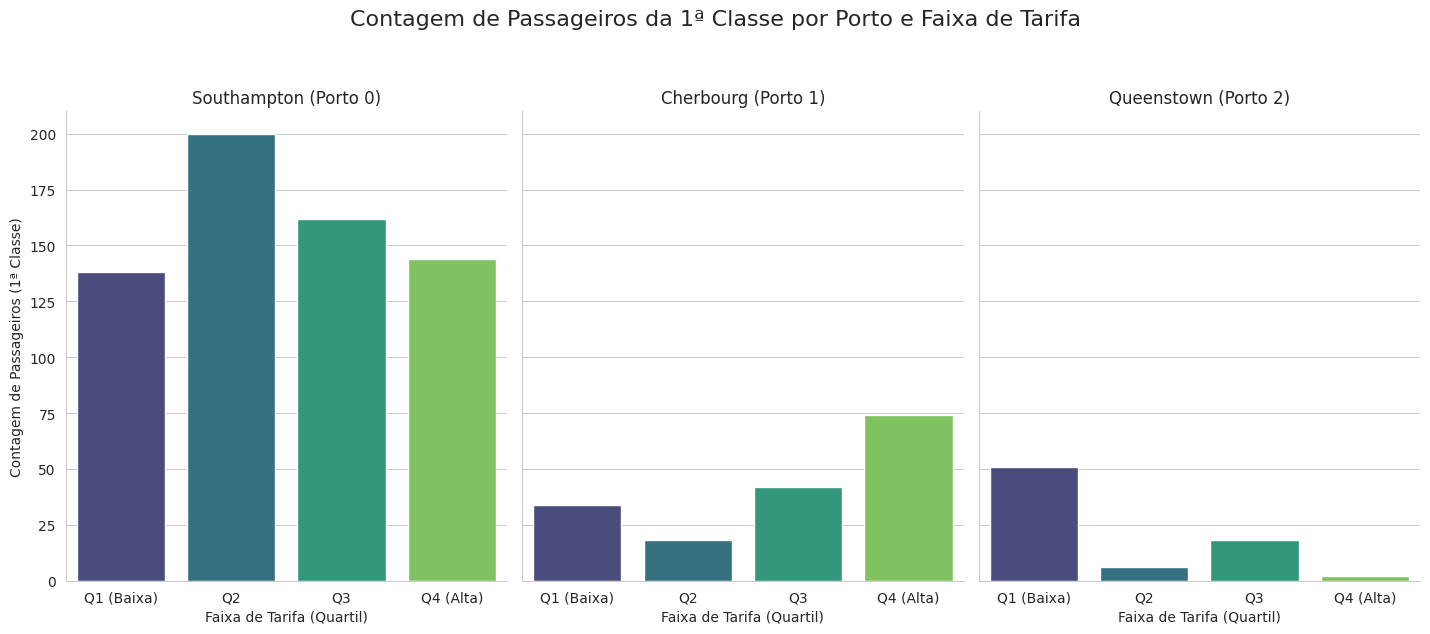

In [135]:
sns.set_style("whitegrid")
g = sns.catplot(
    data=titanic_df,
    kind='count',
    x='Fare',
    col='Embarked',
    palette='viridis',
    height=6,
    aspect=0.8
)

g.fig.suptitle('Contagem de Passageiros da 1ª Classe por Porto e Faixa de Tarifa', y=1.05, fontsize=16)
g.set_axis_labels("Faixa de Tarifa (Quartil)", "Contagem de Passageiros (1ª Classe)")
g.set_xticklabels(['Q1 (Baixa)', 'Q2', 'Q3', 'Q4 (Alta)'])

novos_titulos = {
    0: 'Southampton (Porto 0)',
    1: 'Cherbourg (Porto 1)',
    2: 'Queenstown (Porto 2)'
}

for ax in g.axes.flat:
    try:
        titulo_original = ax.get_title()
        num_str = titulo_original.split('=')[1]
        numero_porto = int(float(num_str))

        if numero_porto in novos_titulos:
            ax.set_title(novos_titulos[numero_porto])
    except:
        pass

plt.tight_layout()
plt.show()

/tmp/ipython-input-1587440084.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


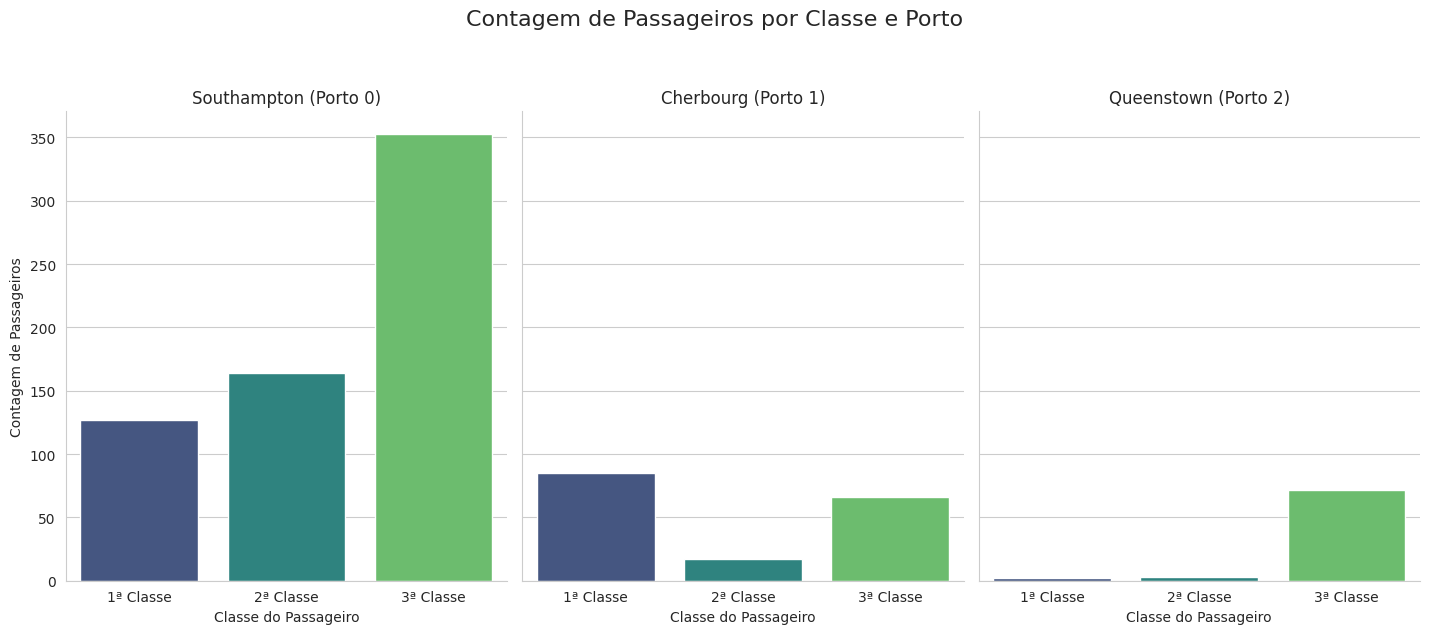

In [136]:
sns.set_style("whitegrid")
g = sns.catplot(
    data=titanic_df,
    kind='count',
    x='Pclass',
    col='Embarked',
    palette='viridis',
    height=6,
    aspect=0.8
)

g.fig.suptitle('Contagem de Passageiros por Classe e Porto', y=1.05, fontsize=16)
g.set_axis_labels("Classe do Passageiro", "Contagem de Passageiros")
g.set_xticklabels(['1ª Classe', '2ª Classe', '3ª Classe'])

novos_titulos = {
    0: 'Southampton (Porto 0)',
    1: 'Cherbourg (Porto 1)',
    2: 'Queenstown (Porto 2)'
}

for ax in g.axes.flat:
    try:
        titulo_original = ax.get_title()
        num_str = titulo_original.split('=')[1]
        numero_porto = int(float(num_str))

        if numero_porto in novos_titulos:
            ax.set_title(novos_titulos[numero_porto])
    except:
        pass

plt.tight_layout()
plt.show()

Aqui, podemos ver que o porto influenciou sim e por um motivo, os passageiros de 1 classe em proporção foram amis forte em Cherboug, mostrando que em porcentagem ali teve a maior taxa de sobrevivencia em relação aos outros, por mais que em numero absoluto Southapton tenha maior numeo de primeira classe, ele possuí uma quantidade esmagadora de de segunda classe e terceira classe. Apos an alisar isso, por mais que  Queenstown possua menos passageiro de primeira classe, devido a quantidade esmagadora de Southampton, torna a taxa de sobrevivencia de queentown mais proeminente, como pode ser analisados em um grafico acima, por mais que não seja uma diferençå gritante.

Após as análises com estes dados, creio que separei corretamente os valores. Tiveram grande influência, em principal, o dinheiro gasto na tarifa (que vai inferir a classe social da pessoa), o sexo (que demonstrou extrema importância) e a idade também, crendo que esses 3 sejam os que podem desempenhar papéis principais,

Partindo para seção de treinamento da maquina

In [138]:
feature_cols = [
    'Pclass',
    'Sex',
    'Age',
    'Embarked',
    'Fare',
    'FamilyGroup'
]

X = titanic_df[feature_cols]
y = titanic_df['Survived']


X_train, X_validation, y_train, y_validation = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)


model = xgb.XGBClassifier(
    seed=42,
    use_label_encoder=False,
    eval_metric='logloss',
    enable_categorical=True
)

print("Iniciando o treinamento do XGBoost...")

model.fit(X_train, y_train)

print("Treinamento concluído!")


predictions = model.predict(X_validation)

accuracy = accuracy_score(y_validation, predictions)

print("------------------------------------------")
print(f"Acurácia no conjunto de validação: {accuracy * 100:.2f}%")
print("------------------------------------------")

Iniciando o treinamento do XGBoost...
Treinamento concluído!
------------------------------------------
Acurácia no conjunto de validação: 82.12%
------------------------------------------


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:23:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
